In [1]:
import pandas as pd
import tarfile
import xml.etree.ElementTree as ET
from xml.dom.minidom import parse, parseString
from collections import Counter
import numpy as np
import re
import csv
from tqdm import tqdm
import csv
import pickle
import matplotlib.pyplot as plt
import time
import os
import xmltodict
from collections.abc import MutableMapping
import copy
import category_encoders as ce
import math
from sklearn.preprocessing import RobustScaler

In [2]:
#pandas settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
df_csv = pd.read_pickle("../3.new_data/2B.df_from_csv_preprocessed.pickle")
df_xml = pd.read_pickle("../3.new_data/2A.df_extracted_xml.pickle")

In [4]:
#GET TENDERS WITH NO LOTS
df_csv = df_csv.loc[df_csv["lots"] == "N"]
#df_xml = df_xml.loc[df_xml["ID_LOT"] == -1]

#CHANGE TYPE FOR MERGING AND DROP DUPLICATES
df_xml["ID_NOTICE_CAN"] = df_xml["ID_NOTICE_CAN"].astype(int)
df_csv = df_csv.drop_duplicates(subset = ["ID_NOTICE_CAN"])
df_xml = df_xml.drop_duplicates(subset = ["ID_NOTICE_CAN"])

len(df_csv)

74144

In [5]:
#MERGE THE DATASETS
df = pd.merge(df_csv, df_xml, on="ID_NOTICE_CAN", how = "left")
len(df)

74144

In [6]:
#REMOVE THE IDENTICAL VALUES FOR ESTIMATES AND AWARD PRICE
df = df.drop(labels=[i for i in range(0, len(df)) if df["AWARD_VALUE_EURO_FIN_1"].iloc[i] == df["AWARD_EST_VALUE_EURO"].iloc[i]], axis = 0).reset_index(drop=True)
len(df)

46990

In [7]:
numerical_cols = ["AWARD_EST_VALUE_EURO", "CRIT_PRICE_WEIGHT", "NUMBER_OFFERS", "AWARD_VALUE_EURO_FIN_1"]
df[numerical_cols] = df[numerical_cols].astype(float)

--------------------------------------------------------
FINAL PREPROCESSING
--------------------------------------------------------
--------------------------------------------------------

In [8]:
#DROP COLUMNS WHICH ARE NOT USED FOR FINAL ANALYSIS
print("CAE_NAME has {} unique values of {} in total".format(len(df["CAE_NAME"].unique()), len(df)))
drop_columns = ["ID_LOT_x", "ID_LOT_y", "lots", "ID_NOTICE_CAN", "LOTS_NUMBER", "CAE_NAME", "duration", "duration type", "date start", "date end", "VALUE_EURO"]
df = df.drop(columns = drop_columns)

#LIST ALL TENDERS with missing values for short description
missing_short_descr = df.loc[pd.isna(df["short description"]) == True].index.tolist()
df = df.drop(labels = missing_short_descr, axis = 0).reset_index(drop=True)

CAE_NAME has 17395 unique values of 46990 in total


42291 values for duration were missing from the 46000 in total <br>
same for date start and end <br>

17395 unique values for name with 46990 total, making them useless as a categorical variable <br>

drop rows without a short description <br>

sub question 1: <br>
PL == 8174 <br>
ES == 6884 <br>
these candidate countries seem like the best candidates for the comparison with rodriguez <br>
compare with the whole dataset <br>
<br>
sub question 2: <br>
get the data for only english <br>

In [9]:
for col in df.columns:
    print(col, ": ", len(df[col].unique()))

ISO_COUNTRY_CODE :  31
CAE_TYPE :  8
MAIN_ACTIVITY :  21
B_ON_BEHALF :  2
B_AWARDED_BY_CENTRAL_BODY :  2
TYPE_OF_CONTRACT :  3
TAL_LOCATION_NUTS :  2647
B_FRA_AGREEMENT :  2
CPV :  45
B_EU_FUNDS :  2
TOP_TYPE :  7
B_ACCELERATED :  2
CRIT_CODE :  2
CRIT_PRICE_WEIGHT :  97
NUMBER_OFFERS :  98
AWARD_EST_VALUE_EURO :  31709
AWARD_VALUE_EURO_FIN_1 :  41935
DT_AWARD :  880
LG_ORIG :  21
short description :  41430
title :  37528
ac criterion :  15984


In [17]:
def make_boxplots(df, columns):
    num_cols = len(columns)
    num_rows = math.ceil(math.sqrt(num_cols))
    num_cols_per_row = math.ceil(num_cols / num_rows)

    plt.figure(figsize=(15, 5 * num_rows))
    fig, axes = plt.subplots(num_rows, num_cols_per_row, figsize=(15, 5 * num_rows))

    # Flatten the axes array to simplify indexing
    axes = axes.flatten()

    for i, column in enumerate(columns):
        ax = axes[i]
        if i < num_cols:
            ax.boxplot(df[column])
            ax.set_title(column)
        else:
            fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

In [30]:
def filter_outliers(df, upper, lower, target_col):
    """This function only works on numerical columns"""
    data_array = np.sort(df[target_col].to_numpy())
    cut_off_low_indice = math.floor(lower * len(data_array))
    cut_off_high_indice = math.floor(upper * len(data_array)) - 1
    low_amount = data_array[cut_off_low_indice]
    high_amount = data_array[cut_off_high_indice]

    outlier_indices = []

    for i in range(0, len(df)):
        if df[target_col].iloc[i] > high_amount:
            outlier_indices.append(i)
        elif df[target_col].iloc[i] < low_amount:
            outlier_indices.append(i)
        else:
            continue

    print("{} rows were dropped because of outliers, with high amount = {}, and low amount = {}".format(len(outlier_indices), high_amount, low_amount))
    df = df.drop(labels = outlier_indices, axis = 0).reset_index(drop=True)
    return df

In [34]:
df = filter_outliers(df, upper = 0.95, lower = 0.08, target_col="AWARD_VALUE_EURO_FIN_1")
df = filter_outliers(df, upper = 0.99, lower = 0.01, target_col="AWARD_EST_VALUE_EURO")

5968 rows were dropped because of outliers, with high amount = 5750000.0, and low amount = 7830.02
799 rows were dropped because of outliers, with high amount = 8302448.62, and low amount = 9585.42


<Figure size 1500x1000 with 0 Axes>

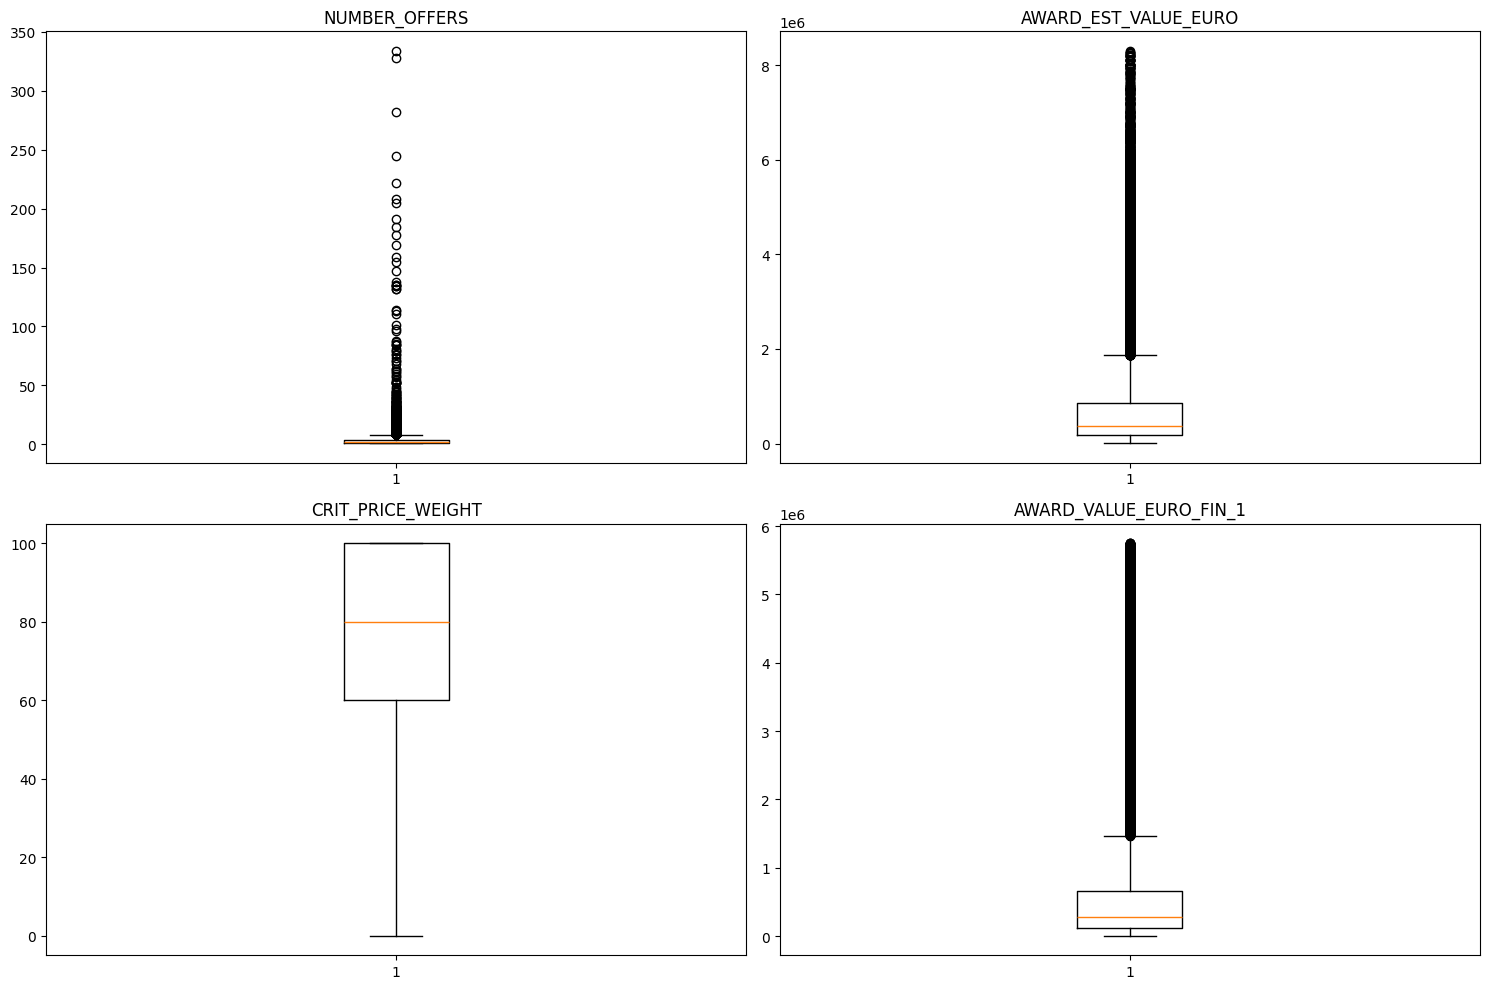

In [35]:
numeric_cols = ["NUMBER_OFFERS", "AWARD_EST_VALUE_EURO", "CRIT_PRICE_WEIGHT", "AWARD_VALUE_EURO_FIN_1"]
make_boxplots(df, columns = numeric_cols)

In [37]:
replication_cols = ["TOP_TYPE", "B_ACCELERATED", "TYPE_OF_CONTRACT", "TAL_LOCATION_NUTS",
                            "CPV", "DT_AWARD", "NUMBER_OFFERS", "AWARD_VALUE_EURO_FIN_1", "AWARD_EST_VALUE_EURO", "ISO_COUNTRY_CODE"]

extension_columns = ["CAE_TYPE", "MAIN_ACTIVITY", "B_ON_BEHALF",
             "B_AWARDED_BY_CENTRAL_BODY", "B_FRA_AGREEMENT", "B_EU_FUNDS", "CRIT_CODE", "CRIT_PRICE_WEIGHT"
             ]

df_structured = df[replication_cols]
df_structured_extension = df[replication_cols + extension_columns]

In [38]:
#COMBINE ALL TEXT DATA
combined_text = []

for i in range(0, len(df)):
    row = df.iloc[i]
    short_descr = df["short description"].iloc[i]
    title = df["title"].iloc[i]
    criterion = df["ac criterion"].iloc[i]

    if pd.isna(criterion) == False and pd.isna(title) == False:
        combined_text.append("{} {} {} ".format(short_descr, criterion, title))
    elif pd.isna(criterion) == True and pd.isna(title) == False:
        combined_text.append("{} {} ".format(short_descr, title))
    if pd.isna(criterion) == False and pd.isna(title) == True:
        combined_text.append("{} {}".format(short_descr, criterion))
    else:
        continue

df["combined text"] = combined_text

In [39]:
#COMBINE SHORT DESCRIPTION WITH CRITERIA
short_descr_criterion = []

for i in range(0, len(df)):
    row = df.iloc[i]
    short_descr = df["short description"].iloc[i]
    criterion = df["ac criterion"].iloc[i]

    if pd.isna(criterion) == False:
        short_descr_criterion.append("{} {}".format(short_descr, criterion))
    else:
        short_descr_criterion.append(short_descr)

df["short_descr_criterion"] = short_descr_criterion

In [40]:
with open("../3.new_data/4A.df_structured_extended", "wb") as f:
    pickle.dump(df_structured_extension, f)

with open("../3.new_data/4B.df_replication", "wb") as f:
    pickle.dump(df_structured, f)

with open("../3.new_data/4C.df_structured_unstructured", "wb") as f:
    pickle.dump(df, f)